# AE 598 HW 2 Tabular Methods
## Alex Hausser

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict

In [2]:
# Initialize
env_slippery = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"], map_name="4x4", is_slippery=True, render_mode=None).unwrapped
env_unslippery = gym.make('FrozenLake-v1', desc=["SFFF", "FHFH", "FFFH", "HFFG"], map_name="4x4", is_slippery=False, render_mode=None).unwrapped
A_size = env_slippery.action_space.n
S_size = env_slippery.observation_space.n

### Plotting and Helper Functions

In [3]:
# Action mapping for FrozenLake: 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP
ACTION_SYMBOLS = {0: '←', 1: '↓', 2: '→', 3: '↑'}
# Known 4x4 layout indices
HOLES = [5, 7, 11, 12]
GOAL = 15
START = 0

def plot_optimal_policy(Q_table):
    """
    Plots the optimal (greedy) policy derived from the Q-table 
    with arrows on the 4x4 FrozenLake grid.
    """
    nrows, ncols = 4, 4
    
    # Extract the best action for each state and reshape
    greedy_policy = np.argmax(Q_table, axis=1)
    grid_policy = greedy_policy.reshape(nrows, ncols)

    # Setup the plot
    fig, ax = plt.subplots(figsize=(ncols, nrows))
    ax.set_xticks(np.arange(ncols))
    ax.set_yticks(np.arange(nrows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.invert_yaxis() 
    
    # Use Q vals for background coloring to add context
    Q_table = np.max(Q_table, axis=1).reshape(nrows, ncols)
    ax.matshow(Q_table, cmap='Blues', alpha=0.5) 

    # Edit each cell with color and symbol
    for r in range(nrows):
        for c in range(ncols):
            state_index = r * ncols + c
            
            # Default is the optimal arrow
            symbol = ACTION_SYMBOLS[grid_policy[r, c]]
            color = 'darkblue'
            font_size = 18

            if state_index in HOLES: 
                symbol = 'H'
                color = 'red'
                font_size = 20
            elif state_index == GOAL: 
                symbol = 'G'
                color = 'green'
                font_size = 20
            elif state_index == START:
                 color = 'purple'
            
            ax.text(c, r, symbol, ha='center', va='center', color=color, fontsize=font_size, fontweight='bold')
    
    # Add grid lines
    ax.set_xticks(np.arange(ncols + 1) - .5, minor=True)
    ax.set_yticks(np.arange(nrows + 1) - .5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)

    plt.show()
    
#################################################    

# Define a palette for consistent algorithm colors
ALGO_COLORS = {
    "MC Control": "#0077b6",  
    "SARSA": "#cc3333",       
    "Q-Learning": "#339966"
}

def plot_single_run_evaluation(evaluation_data_list, algorithm_names, ylim):
    """
    Plots the evaluation returns over cumulative training steps for multiple algorithms.
    
    Args:
        evaluation_data_list: A list where each element is the evaluation data
                              [(cumulative_steps, avg_return), ...] for one algorithm.
        algorithm_names: A list of strings containing the name for each algorithm.
    """

    # --- Plotting Loop for Multiple Algorithms ---
    for data_index, evaluation_data in enumerate(evaluation_data_list):
        algo_name = algorithm_names[data_index]

        # Extract x (cumulative_steps) and y (avg_returns) data
        cumulative_steps = [data[0] for data in evaluation_data]
        avg_returns = [data[1] for data in evaluation_data]
        
        # Get color from the defined palette
        plot_color = ALGO_COLORS.get(algo_name)
        
        # Plot the evaluation returns
        plt.plot(
            cumulative_steps, 
            avg_returns, 
            markersize=4,       
            linestyle='-', 
            linewidth=2,
            color=plot_color, 
            label=algo_name
        )

    # Make look nice
    plt.xlabel('Cumulative Training Time Steps', fontsize=14) 
    plt.ylabel('Average Evaluation Return', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=12)
    plt.ylim(bottom=0.0, top=ylim)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) 
    
    plt.tight_layout()
    plt.show()

#################################################

def evaluate_policy(env, Q_table, num_eval_episodes=100, gamma=0.95):
    """
    Evaluates the greedy policy derived from the Q_table over a fixed number of episodes.
    
    Args:
        env: The FrozenLake environment
        Q_table: The current action-value function table (Q-table)
        num_eval_episodes: The number of independent episodes to run for evaluation
        gamma: Discount factor
        
    Returns:
        avg_discounted_return: The average discounted return over the evaluation episodes.
    """
    total_returns = []

    for _ in range(num_eval_episodes):
        state, _ = env.reset()
        episode_return = 0
        discount = 1.0
        
        while True:
            # Find the max Q-value for the current state
            q_values = Q_table[state]
            max_q = np.max(q_values)
            
            # Find all actions that achieve the maximal Q-value (tie-breaking)
            optimal_actions = np.where(q_values == max_q)[0]
            
            # Randomly choose one of the optimal actions
            action = np.random.choice(optimal_actions) 
            
            state, reward, terminated, truncated, _ = env.step(action)
            
            # Calculate discounted return G
            episode_return += discount * reward
            discount *= gamma
            
            if terminated or truncated:
                break
                
        total_returns.append(episode_return)
        
    return np.mean(total_returns)

################################################
def epsilon_greedy(state, Q, epsilon, env):
    """
    Selects an action using the epsilon-greedy policy.
    Args:
        state: The current state.
        Q: The action-value function.
        epsilon: The probability of choosing a random action.
        env: The environment.
        
    Returns:
        action: The action to take.
    """
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # explore
    else:
        return np.argmax(Q[state])        # exploit

### MC Method

In [4]:
def MC_control(env, num_episodes, gamma=0.95, epsilon=0.35, eval_interval=10000):
    """
    On-policy First Visit Monte Carlo Control for epsilon-soft policies.
    Args:
        env: The environment
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        epsilon: Probability of choosing a random action
        eval_interval: Number of learning updates between evaluations
    
    Returns:
        Q: The optimal action-value function
        opt_policy_greedy: The optimal policy
        evaluation_data: List of (cumulative_updates, avg_return) tuples for each evaluation
    """
    # Initializations
    A_size = env.action_space.n
    S_size = env.observation_space.n
    Q = np.zeros((S_size, A_size))
    policy = np.ones((S_size, A_size)) / A_size
    
    # Learning tracking
    evaluation_data = []
    cumulative_updates = 0
    next_eval_time = eval_interval 
    
    # Initialize Returns dictionary
    Returns = {} 
    for s in range(S_size):
        for a in range(A_size):
            Returns[(s, a)] = []
    
    # Loop through each episode
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_data = []
        
        # Generate an episode until termination
        while True:
            action = epsilon_greedy(state, Q, epsilon, env) 
            s_prime, reward, terminated, truncated, _ = env.step(action) 
            episode_data.append((state, action, reward))
            state = s_prime
            if terminated or truncated:
                break
            
        # Initialize return
        G = 0
        # Keep track of visited state-action pairs
        visited_sa_pairs = set()
        updates_in_episode = 0
        
        # Loop backwards through the episode
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward
            
            # First visit check
            if (state, action) not in visited_sa_pairs:
                # Mark this state-action pair as visited
                visited_sa_pairs.add((state, action))
                # Append the return to the list of returns
                Returns[(state, action)].append(G)
                # Update Q value using average of returns
                Q[state, action] = np.mean(Returns[(state, action)])
                # Find the best action for the current state
                A_star = np.argmax(Q[state, :])

                # Policy Improvement based on epsilon-soft policy
                for a in range(A_size):
                    if a == A_star:
                        policy[state, a] = 1 - epsilon + (epsilon / A_size)
                    else:
                        policy[state, a] = (epsilon / A_size)
                        
                updates_in_episode += 1
        
        # Check number of learning updates
        cumulative_updates += updates_in_episode
        if cumulative_updates >= next_eval_time:
            # Perform Evaluation
            avg_return = evaluate_policy(env, Q, num_eval_episodes=100, gamma=gamma)
            
            # Record the result using the actual update count
            evaluation_data.append((cumulative_updates, avg_return))
            
            # Update the next evaluation time
            while cumulative_updates >= next_eval_time:
                next_eval_time += eval_interval

        
        # Optimal Policy (Greedy)                
        opt_policy_greedy = np.argmax(Q, axis=1)
    
        env.close()
                            
    return Q, opt_policy_greedy, evaluation_data

### SARSA

In [5]:
def sarsa_control(env, num_episodes, gamma=0.95, alpha=0.1, epsilon=0.35, eval_interval=10000):
    """
    Sarsa (On-Policy TD Control)
    
    Args:
        env: The environment.
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        alpha: Learning rate
        epsilon: Probability of choosing a random action (for epsilon-greedy behavior)
        eval_interval: Number of cumulative updates between policy evaluations
    
    Returns:
        Q: The optimal action-value function
        opt_policy_greedy: The optimal policy
        evaluation_data: List of (cumulative_updates, avg_return) tuples
    """
    # Initializations
    A_size = env.action_space.n
    S_size = env.observation_space.n
    Q = np.zeros((S_size, A_size))
    
    # Learning tracking
    evaluation_data = []
    cumulative_updates = 0
    next_eval_time = eval_interval 
    
    # Loop through each episode
    for episode in range(num_episodes):
        
        # Initialize S
        S, _ = env.reset()
        
        # Choose A from S using policy derived from Q
        A = epsilon_greedy(S, Q, epsilon, env) 
        
        # Loop for each step of episode
        while True:
            # Take action A, observe R, S'
            S_prime, R, terminated, truncated, _ = env.step(A)
            
            # Check for terminal state
            if terminated or truncated:
                # Update Q for the terminal step
                Q[S, A] = Q[S, A] + alpha * (R - Q[S, A])
                
                cumulative_updates += 1
                break
                
            # Choose A' from S' using policy derived from Q
            A_prime = epsilon_greedy(S_prime, Q, epsilon, env)
            
            # TD Target and Error
            td_target = R + gamma * Q[S_prime, A_prime]
            td_error = td_target - Q[S, A]
            # Update Q value
            Q[S, A] = Q[S, A] + alpha * td_error
            
            # Increment update count
            cumulative_updates += 1
            
            # Advance state-action pair
            S = S_prime
            A = A_prime

            # Evaluation Return Tracking
            if cumulative_updates >= next_eval_time:
                # Perform Evaluation
                avg_return = evaluate_policy(env, Q, num_eval_episodes=100, gamma=gamma)
                
                # Record the result using the actual update count
                evaluation_data.append((cumulative_updates, avg_return))
                
                # Update the next evaluation time
                while cumulative_updates >= next_eval_time:
                    next_eval_time += eval_interval

        # Optimal Policy
        opt_policy_greedy = np.argmax(Q, axis=1)
                        
    return Q, opt_policy_greedy, evaluation_data

### Q-Learning

In [6]:
def q_learning_control(env, num_episodes, gamma=0.95, alpha=0.1, epsilon=0.35, eval_interval=10000):
    """
    Q-Learning (Off-Policy TD Control)
    
    Args:
        env: The environment
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        alpha: Learning rate
        epsilon: Probability of choosing a random action (for epsilon-greedy behavior)
        eval_interval: Number of cumulative updates between policy evaluations
    
    Returns:
        Q: The optimal action-value function
        opt_policy_greedy: The optimal deterministic policy
        evaluation_data: List of (cumulative_updates, avg_return) tuples
    """
    # Initializations
    A_size = env.action_space.n
    S_size = env.observation_space.n
    Q = np.zeros((S_size, A_size))
    
    # Learning tracking
    evaluation_data = []
    cumulative_updates = 0
    next_eval_time = eval_interval 
    
    # Loop through each episode:
    for episode in range(num_episodes):
        
        # Initialize S
        S, _ = env.reset()
        
        # Loop for each step of episode
        while True:
            # Choose A from S using policy derived from Q
            A = epsilon_greedy(S, Q, epsilon, env) 
            
            # Take action A, observe R, S'
            S_prime, R, terminated, truncated, _ = env.step(A)
            
            # Check for terminal state after observing S' and R
            if terminated or truncated:
                # Update Q for the terminal step
                Q[S, A] = Q[S, A] + alpha * (R - Q[S, A])
                
                cumulative_updates += 1
                break
                
            # Q-Learning TD Target (Off-Policy Step)
            max_Q_prime = np.max(Q[S_prime, :])
            
            # Update Q value
            td_target = R + gamma * max_Q_prime
            Q[S, A] = Q[S, A] + alpha * (td_target - Q[S, A])
            
            # Increment update count
            cumulative_updates += 1
            
            # Advance state and the action chosen from new state
            S = S_prime
            A = epsilon_greedy(S, Q, epsilon, env) 

            # Evaluation Return Tracking
            if cumulative_updates >= next_eval_time:
                # Perform Evaluation
                avg_return = evaluate_policy(env, Q, num_eval_episodes=100, gamma=gamma)
                
                # Record the result using the actual update count
                evaluation_data.append((cumulative_updates, avg_return))
                
                # Update the next evaluation time
                while cumulative_updates >= next_eval_time:
                    next_eval_time += eval_interval

        # Optimal Policy
        opt_policy_greedy = np.argmax(Q, axis=1)
                        
    return Q, opt_policy_greedy, evaluation_data

### Plotting

MC Control Slippery

In [7]:
opt_MC_Q_slippery, opt_MC_policy_slippery, opt_MC_eval_data_slippery = MC_control(env_slippery, num_episodes=10000, eval_interval=1000)

MC Control Unslippery

In [8]:
opt_MC_Q_unslippery, opt_MC_policy_unslippery, opt_MC_eval_data_unslippery = MC_control(env_unslippery, num_episodes=10000, eval_interval=1000)

SARSA Slippery

In [9]:
opt_SARSA_Q_slippery, opt_SARSA_policy_slippery, opt_SARSA_eval_data_slippery = MC_control(env_slippery, num_episodes=10000, eval_interval=1000)

SARSA Unslippery

In [10]:
opt_SARSA_Q_unslippery, opt_SARSA_policy_unslippery, opt_SARSA_eval_data_unslippery = MC_control(env_unslippery, num_episodes=10000, eval_interval=1000)

Q-Learning Slippery

In [11]:
opt_Q_Learning_Q_slippery, opt_Q_Learning_policy_slippery, opt_Q_Learning_eval_data_slippery = MC_control(env_slippery, num_episodes=10000, eval_interval=1000)

Q-Learning Unslippery

In [12]:
opt_Q_Learning_Q_unslippery, opt_Q_Learning_policy_unslippery, opt_Q_Learning_eval_data_unslippery = MC_control(env_unslippery, num_episodes=10000, eval_interval=1000)

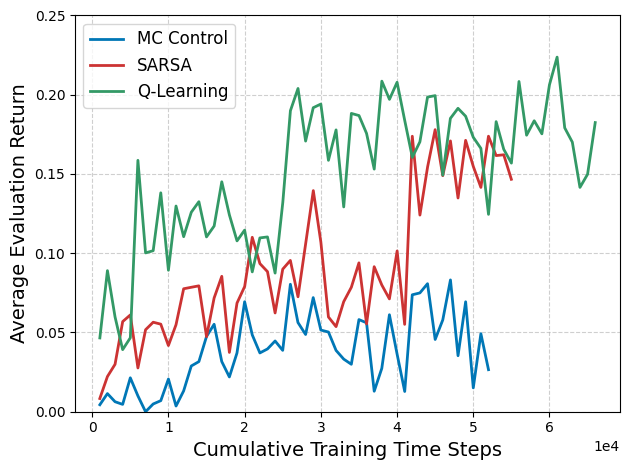

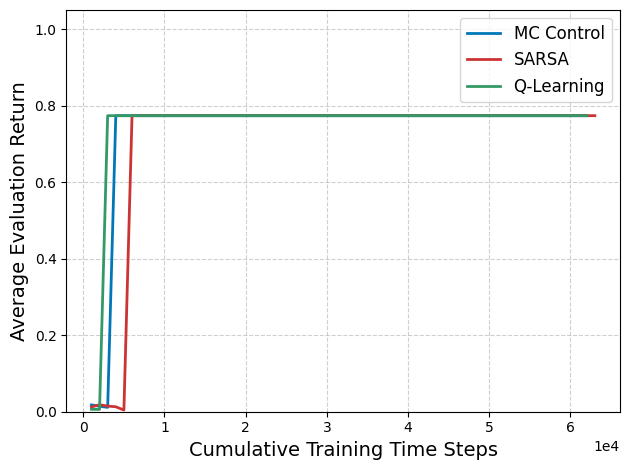

In [13]:
plot_single_run_evaluation([opt_MC_eval_data_slippery, opt_SARSA_eval_data_slippery, opt_Q_Learning_eval_data_slippery], ["MC Control", "SARSA", "Q-Learning"], 0.25)
plot_single_run_evaluation([opt_MC_eval_data_unslippery, opt_SARSA_eval_data_unslippery, opt_Q_Learning_eval_data_unslippery], ["MC Control", "SARSA", "Q-Learning"], 1.05)

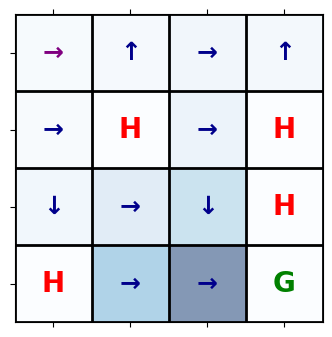

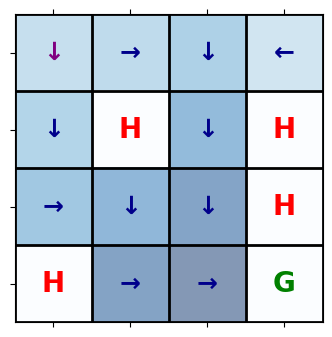

In [14]:
plot_optimal_policy(opt_MC_Q_slippery)
plot_optimal_policy(opt_MC_Q_unslippery)

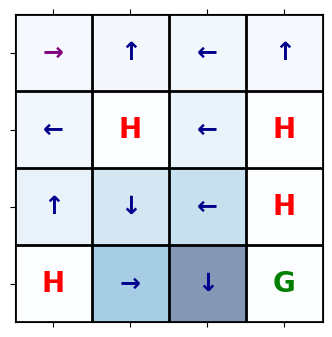

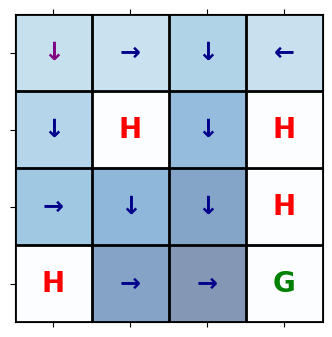

In [15]:
plot_optimal_policy(opt_SARSA_Q_slippery)
plot_optimal_policy(opt_SARSA_Q_unslippery)

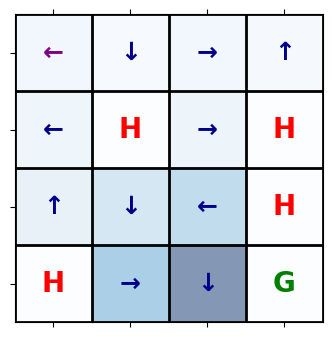

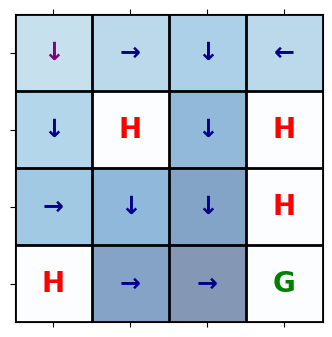

In [16]:
plot_optimal_policy(opt_Q_Learning_Q_slippery)
plot_optimal_policy(opt_Q_Learning_Q_unslippery)